# INFO-F-422 Project 23-24 : Zindi: - Urban Air Pollution Challenge - 

## Description of the Project

### Problem

### Data

### scoring metric

## Tasks

### Packages

In [2]:
library(dplyr)
library(randomForest)
library(ggplot2)
library(RSNNS)
library(e1071)
library(xgboost)
library(keras)
library(repr)
library(caret)
library(lubridate)
library(VIM)
library(lightgbm)

options(repr.matrix.max.cols=500, repr.matrix.max.rows=200)
#set.seed(42)

### 1. Pipeline
This section will contain a few functions that can be called to modify, complete or create new features.`

These Functions can then after be called easilly to try different combinations.

#### Data importation & Feature selection

2 simple functions that helps getting a clean data easilly for each model

In [3]:
get_train_data <- function() {
    train_df <- read.csv("Train.csv")
    train_df <- train_df %>% 
        select(-"target_min", -"target_max",-"target_variance",-"target_count")
    return(train_df)
}

In [4]:
get_test_data <- function() {
    train_df <- read.csv("Test.csv")
    return(train_df)
}

#### Missing value imputation

Different methods that can be applied to the data in order avoid keeping empty data in the datasets.
1. This method simply deletes all columns containing nan's and keeps only the ones that are complete. This method is quite drastic and reduces a lot our dataset.
2. The second method will tranform all the nan's in the data by the mean of that column. This allows to keep all the original data.
3. The third method will tranform all the nan's in the data by the median of that column. This allows to keep all the original data.
4. The fourth method will tranform all the nan's in the data by the median of that column but grouped for each station. alowing us to keep all the data and also laverage the information of the median of the area.

In [5]:
# Drop na's
drop_na <- function(data) {
    data_clean <- data[, colSums(is.na(data)) == 0]
    return(data_clean)
}

In [6]:
# Replace na's by mean
na_to_mean <- function(data) {
    data_clean <- data %>%
        mutate(across(everything(), ~ifelse(is.na(.), mean(., na.rm = TRUE), .)))
    return(data_clean)
}

In [7]:
# Replace na's by median
na_to_median <- function(data) {
    data_clean <- data %>%
        mutate(across(everything(), ~ifelse(is.na(.), median(., na.rm = TRUE), .)))
    return(data_clean)
}

In [8]:
# Replace NA's by the median by Place_ID
na_to_median_by_location <- function(data) {
    # Step 1: Replace NA's within each Place_ID group
    data_clean <- data %>%
        group_by(Place_ID) %>%
        mutate(across(where(is.numeric), ~ifelse(is.na(.), median(., na.rm = TRUE), .))) %>%
        ungroup()

    # Step 2: Calculate global medians for each numeric column
    global_medians <- data %>%
        summarize(across(where(is.numeric), median, na.rm = TRUE)) %>%
        unlist()
    
    # Step 3: Replace remaining NA's with global medians
    data_clean <- data_clean %>%
        mutate(across(where(is.numeric), ~ifelse(is.na(.), global_medians[cur_column()], .)))

    return(data_clean)
}


#### Normalization

That function will normalize the whole dataset pet column. (the function scale will also be used later)

In [9]:
#Function that will normalize all the columns
normalize <- function(x) {
  (x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE))
}

#### Feature engineering

In [10]:
# Add columns for day, mounth, year, day of the week and if it is weekend or not.
add_time <- function(data) {
    data <- data %>%
        mutate(day = day(Date),
               month = month(Date),
               day_of_week = wday(Date),
               s_weekend = as.integer(wday(Date) %in% c(6, 7)))
    data <- data %>%
        group_by(Place_ID) %>%
        mutate(placeID_freq = n()) %>%
        ungroup()

    return(data)
}

In [11]:
# Function to add lag, lead of all the columns enabeling it to see what was before and after
add_lag_lead <- function(data, days) {
    # Features: Excluding specific columns from the dataset
    features <- setdiff(names(data), c("Date", "target_count", "target_min", "Place_ID X Date", "target_variance", "target_max", "Place_ID.X.Date", "target"))
    
    numeric_features <- sapply(data, is.numeric)
    features <- names(numeric_features[numeric_features == TRUE])
    features <- setdiff(features, c("target", "Place_ID.X.Date", "Date"))
    
    # Wrap operations in a group_by() without arranging
    data <- data %>%
        group_by(Place_ID) %>%
        mutate(across(all_of(features), ~lag(.x, 1), .names = "prev_{.col}_1"),
               across(all_of(features), ~lead(.x, 1), .names = "next_{.col}_1")) %>%
        ungroup()  # Return to regular data frame operation without groups
    
    # Now create the difference features
    for (i in 1:days) {
        # Creating difference features for lag
        data <- data %>%
            group_by(Place_ID) %>%
            mutate(across(all_of(features), ~. - lag(., i), .names = paste0("prev_{.col}_", i+1))) %>%
            ungroup()
        
        # Creating difference features for lead
        data <- data %>%
            group_by(Place_ID) %>%
            mutate(across(all_of(features), ~. - lead(., i), .names = paste0("next_{.col}_", i+1))) %>%
            ungroup()
    }
    
    # Replace NA values in numeric columns with 0
    numeric_columns <- sapply(data, is.numeric)
    data[numeric_columns] <- lapply(data[numeric_columns], function(x) replace(x, is.na(x), 0))
    
    return(data)
}


#### Divide train / validation set

In [12]:
# randomise stations in train and val by grouping the Place_ID's
# This allows to not overfit with the test data that doesn't contain similar Place_ID's as the training data
get_train_val <- function(data, rep) {
    unique_place_ids <- unique(data$Place_ID)
    shuffled_place_ids <- sample(unique_place_ids)
    unique_place_ids <- unique(data$Place_ID)
    shuffled_place_ids <- sample(unique_place_ids)
    num_train <- round(length(shuffled_place_ids) * rep)
    train_ids <- shuffled_place_ids[1:num_train]
    val_ids <- shuffled_place_ids[(num_train + 1):length(shuffled_place_ids)]
    train <- data[data$Place_ID %in% train_ids, ] %>% 
      select(-"Place_ID")
    val <- data[data$Place_ID %in% val_ids, ] %>% 
      select(-"Place_ID")
    return(list(train = train, val = val))
}

#### Configuration grid example
This allows to decide for each test which missing value imputation, normalization, feature engeneering and train_val repartition to use

In [13]:
train = get_train_data()
test = get_test_data()
data <- bind_rows(train, test)
data <- na_to_median_by_location(data)
data <- add_time(data)
data <- add_lag_lead(data,10)
features <- setdiff(names(data), c("Date", "Place_ID X Date","Place_ID.X.Date"))
train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]
data_train_val <- get_train_val(train_data ,0.8)

Warning message:
"There was 1 warning in `summarize()`.
ℹ In argument: `across(where(is.numeric), median, na.rm = TRUE)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))"


#### Plot repartition of the data

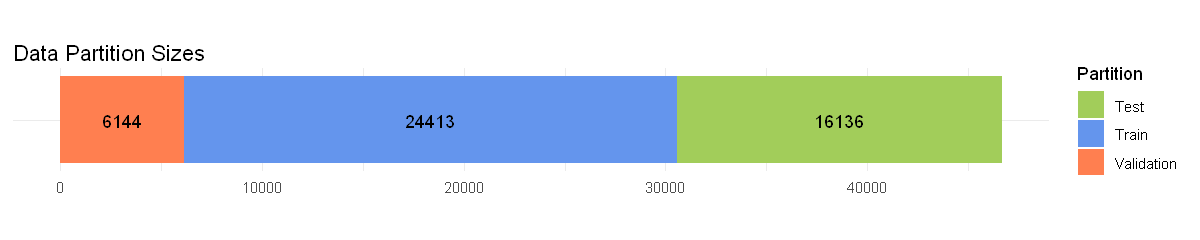

In [14]:
partition_sizes <- data.frame(
  Partition = c("Train", "Validation", "Test"),
  Size = c(nrow(data_train_val$train), nrow(data_train_val$val), nrow(test_data))
)

# Plot the partition sizes
options(repr.plot.width = 10, repr.plot.height = 2)
ggplot(partition_sizes, aes(x = "", y = Size, fill = Partition)) +
  geom_bar(stat = "identity", width = 1) +
  coord_flip() +
  geom_text(aes(label = Size), position = position_stack(vjust = 0.5)) +
  theme_minimal() +
  labs(title = "Data Partition Sizes", x = NULL, y = NULL) +
  scale_fill_manual(values = c("Train" = "cornflowerblue", "Validation" = "coral", "Test" = "darkolivegreen3")) +
  theme(
    axis.ticks = element_blank(), 
    axis.text.y = element_blank(),
    aspect.ratio = 1/10 # Adjust the aspect ratio to make the plot shorter
  )

### 2. Model selection

#### Data preparation for all models

###### Input configuration

In [15]:
train = get_train_data()
test = get_test_data()
data <- bind_rows(train, test)
data <- na_to_median_by_location(data)
#data
data <- add_time(data)
#data <- add_lag_lead(data,10)
features <- setdiff(names(data), c("Date", "Place_ID.X.Date"))
train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]
data_train_val <- get_train_val(train_data ,0.8)

In [16]:
train_x <- data_train_val$train %>% select(-c(target)) %>% as.matrix()
train_y <- data_train_val$train$target

val_x <- data_train_val$val %>% select(-target) %>% as.matrix()
val_y <- data_train_val$val$target

# Normalize the features (if necessary)
train_x_norm <- scale(train_x)
val_x_norm <- scale(val_x)

#### Neural Network

In [28]:
create_nn_model <- function(input_shape) {
  nn_model <- keras_model_sequential() %>%
    layer_dense(units = 128, activation = 'relu', input_shape = input_shape) %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 1)
  
  nn_model %>% compile(
    loss = 'mse',  # Mean Squared Error for regression
    optimizer = 'adam',  # Adaptive moment estimation
    metrics = c('mean_absolute_error')
  )
  
  return(nn_model)
}

# Create the model
input_shape <- ncol(train_x)
model <- create_nn_model(input_shape)

# Train the model
history <- model %>% fit(
  train_x_norm, train_y,
  epochs = 1000,
  batch_size = 32,
  validation_split = 0.2
)

# Make predictions on the validation data
predictions <- model %>% predict(val_x_norm)
rmse <- sqrt(mean((predictions - val_y)^2))
score_nn = rmse
print(paste("RMSE: ", rmse))

ERROR: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <Sequential name=sequential, built=False> (of type <class 'keras.src.models.sequential.Sequential'>)

#### Neural Network from Chat GPT

In [46]:
library(keras)

# Define the function to create the model
create_nn_model <- function(input_shape) {
  nn_model <- keras_model_sequential() %>%
    layer_dense(units = 128, activation = 'relu', input_shape = input_shape) %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 1)
  
  nn_model %>% compile(
    loss = 'mse',  # Mean Squared Error for regression
    optimizer = 'adam',  # Adaptive moment estimation
    metrics = c('mean_absolute_error')
  )
  
  return(nn_model)
}

# Assuming you have train_x, train_y, val_x_norm, val_y, and train_x_norm defined somewhere
input_shape <- dim(train_x)[2]  # Adjust based on your data structure
model <- create_nn_model(input_shape)

# Train the model
history <- model %>% fit(
  train_x_norm, train_y,
  epochs = 1000,
  batch_size = 32,
  validation_split = 0.2
)

# Make predictions on the validation data
predictions <- model %>% predict(val_x_norm)
rmse <- sqrt(mean((predictions - val_y)^2))
score_nn <- rmse
print(paste("RMSE: ", rmse))


ERROR: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <Sequential name=sequential_1, built=False> (of type <class 'keras.src.models.sequential.Sequential'>)

#### RSNNS

In [29]:
control <- trainControl(method = "none")
RSNNS_model <- train(train_x_norm, train_y, method = "mlp", trControl = control)

In [30]:
predictions <- predict(RSNNS_model, val_x_norm)
rmse <- sqrt(mean((predictions - val_y)^2))
score_rsnns = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 47.3756663368529"


#### SVM

In [31]:
svm_model <- svm(target ~ ., data = data_train_val$train)

In [32]:
predictions <- predict(svm_model, val_x)
rmse <- sqrt(mean((predictions - val_y)^2))
score_svm = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 27.258724058156"


#### Randomforest

In [33]:
rf_model <- randomForest(target ~ ., data = data_train_val$train)

In [34]:
predictions <- predict(rf_model, val_x)
rmse <- sqrt(mean((predictions - val_y)^2))
score_rf = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 27.3169107939007"


#### Comparison

In [36]:
# Create a dataframe with RMSE values
rmse_df <- data.frame(
  Model = c("Neural Network", "RSNNS", "SVM", "Random Forest"),
  RMSE = c(score_nn, score_rsnns, score_svm, score_rf))

# Plot RMSE values
ggplot(rmse_df, aes(x = Model, y = RMSE, fill = Model)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  ggtitle("Model Comparison Based on RMSE")

ERROR: Error in eval(expr, envir, enclos): objet 'score_nn' introuvable


### 3. Other model implementation

#### XGBoost

###### Input configuration

In [37]:
train = get_train_data()
test = get_test_data()
data <- bind_rows(train, test)
data <- na_to_median_by_location(data)
#data
data <- add_time(data)
#data <- add_lag_lead(data,10)
features <- setdiff(names(data), c("Date", "Place_ID.X.Date"))
train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]
data_train_val <- get_train_val(train_data ,0.8)

In [38]:
train_x <- data_train_val$train %>% select(-c(target)) %>% as.matrix()
train_y <- data_train_val$train$target

val_x <- data_train_val$val %>% select(-target) %>% as.matrix()
val_y <- data_train_val$val$target

# Normalize the features (if necessary)
#train_x_norm <- scale(train_x)
#val_x_norm <- scale(val_x)

###### Implementation

In [39]:
train_x_matrix <- as.matrix(train_x)
train_y_vector <- as.numeric(train_y)
dtrain <- xgb.DMatrix(data = train_x, label = train_y)

xgb_model <- xgb.train( data = dtrain, nrounds = 50)

In [40]:
dval <- xgb.DMatrix(data = val_x)
predictions <- predict(xgb_model, dval)
rmse <- sqrt(mean((predictions - val_y)^2))
score_xgb = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 34.4893738911475"


#### LGB model

###### Input configuration

In [19]:
train = get_train_data()
test = get_test_data()
data <- bind_rows(train, test)
data <- na_to_median_by_location(data)
#data
data <- add_time(data)
#data <- add_lag_lead(data,10)
features <- setdiff(names(data), c("Date", "Place_ID.X.Date"))
train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]
data_train_val <- get_train_val(train_data ,0.8)

In [20]:
train_x <- data_train_val$train %>% select(-c(target)) %>% as.matrix()
train_y <- data_train_val$train$target

val_x <- data_train_val$val %>% select(-target) %>% as.matrix()
val_y <- data_train_val$val$target

# Normalize the features (if necessary)
#train_x_norm <- scale(train_x)
#val_x_norm <- scale(val_x)

###### Implementation

In [21]:
dtrain <- lgb.Dataset(data = train_x, label = train_y, free_raw_data = FALSE)
dtest <- lgb.Dataset(data = val_x, label = val_y, free_raw_data = FALSE)

# Parameters setup for LightGBM
params <- list(
    objective = "regression",
    metric = "rmse")

# Train the LightGBM model with early stopping
lgb_model <- lgb.train(
  params = params,
  data = dtrain)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18947
[LightGBM] [Info] Number of data points in the train set: 24446, number of used features: 79
[LightGBM] [Info] Start training from score 59.388464


In [22]:
predictions <- predict(lgb_model, val_x)
rmse <- sqrt(mean((predictions - val_y)^2))
score_lgb = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 36.2152714373312"


#### Comparison

In [45]:
# Create a dataframe with RMSE values
rmse_df <- data.frame(
  Model = c("Neural Network", "RSNNS", "SVM", "Random Forest", "XGBost", "Light Gradient Boost"),
  RMSE = c(score_nn, score_rsnns, score_svm, score_rf, score_xgb, score_lgb))

# Plot RMSE values
ggplot(rmse_df, aes(x = Model, y = RMSE, fill = Model)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  ggtitle("Model Comparison Based on RMSE")

ERROR: Error in eval(expr, envir, enclos): objet 'score_nn' introuvable


### 4. Zindi completition upload

### 5. ranking of the features

In [23]:
#Deriving the 10 most relevant features from our lgb model
importance <- lgb.importance(lgb_model,percentage=TRUE)
top_10_features <- head(importance$Feature, 10)
top_10_features

[1] "L3_CO_CO_column_number_density"                     
 [2] "L3_NO2_NO2_slant_column_number_density"             
 [3] "L3_CH4_CH4_column_volume_mixing_ratio_dry_air"      
 [4] "L3_HCHO_tropospheric_HCHO_column_number_density"    
 [5] "u_component_of_wind_10m_above_ground"               
 [6] "temperature_2m_above_ground"                        
 [7] "L3_AER_AI_sensor_altitude"                          
 [8] "L3_CH4_aerosol_optical_depth"                       
 [9] "v_component_of_wind_10m_above_ground"               
[10] "L3_HCHO_tropospheric_HCHO_column_number_density_amf"

In [24]:
col_to_exclude <- setdiff(colnames(data),c("Place_ID", top_10_features)) #keep Place_ID to be able to run get_train_val
X<-data[,setdiff(c(top_10_features, "Place_ID"), col_to_exclude)]
Y<-data[,"target"]

# to access the values I need to write Y$target

In [328]:
XwithTarget <- cbind(X, Target=Y)
head(XwithTarget)

,L3_CO_CO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_optical_depth,L3_AER_AI_sensor_altitude,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_tropospheric_NO2_column_number_density,Place_ID,target
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,0.02108025,6.388800e-05,0.0001558203,1793.794,0.010579039,840209.9,18.51684,1.996377,-1.2273949,1.703769e-05,010Q650,38
2,0.02201668,1.709871e-04,0.0001968663,1789.960,0.015104382,840772.9,22.54653,3.330430,-1.1881078,2.138147e-05,010Q650,39
3,0.02067673,1.239003e-04,0.0001704180,1789.960,0.008326672,841410.7,27.03103,5.065727,3.5005591,7.482015e-06,010Q650,24
4,0.02120710,8.075774e-05,0.0001748593,1789.960,0.008326672,841103.2,23.97186,3.004001,1.0994678,2.302473e-05,010Q650,49
5,0.03776556,1.402194e-04,0.0001415511,1789.960,0.008326672,840763.1,16.81631,2.621787,2.6705589,8.744767e-06,010Q650,21
6,0.02948608,9.418034e-05,0.0001455166,1789.960,0.008326672,840356.8,19.17489,2.955603,0.9690747,1.169355e-05,010Q650,28


In [262]:
head(Y$target)

[1] 38 39 24 49 21 28

In [250]:
test_model <- lgb.train(params = params, train_test)

ERROR: Error in self$set_field(field_name = names(p), data = p[[1L]]): l'objet 'list' ne peut être converti automatiquement en un type 'double'


#### Create a function that creates LGB models with $X^{-i}$ features

In [66]:
create_minus_i_model <- function(X, Y, i) {
#First step is to create the X-i data frame to be able to create our lgb model
    X_minus_i <- X[, -i]
    data_for_train <- cbind(X_minus_i, Target = Y)
    
    rmse_list <- vector("numeric", 50)

    for (j in 1:50) {
    #split the data in train and validation data
    XminusI_train_val <- get_train_val(data_for_train, 0.8)

    train_X <- XminusI_train_val$train %>% select(-c(target)) %>% as.matrix()
    train_Y <- XminusI_train_val$train$target

    val_X <- XminusI_train_val$val %>% select(-target) %>% as.matrix()
    val_Y <- XminusI_train_val$val$target

   
    #Convert Data to LGB Dataset Format
    d_train <- lgb.Dataset(data = as.matrix(train_X), label = train_Y)
    d_val <- lgb.Dataset(data = as.matrix(val_X), label = val_Y, free_raw_data = FALSE)
    
    #set parameters
    params <- list(
        objective = "regression",
        metric = "rmse",
        force_col_wise=TRUE,
        num_leaves=50,
        max_depth = -1
        )
    
    #train the model
    model_i <- lgb.train(params = params,
        data = d_train,
        nrounds = 200,
        early_stopping_rounds = 10,
        valids = list(test = d_val),
        verbose = 0
        )
    
    pred <- predict(model_i, as.matrix(val_X))
    # For regression
    rmse <- sqrt(mean((pred - val_Y)^2))
    
    rmse_list[j] <- round(rmse, 4)
    }

    mean_rmse <- mean(rmse_list)
    return(round(mean_rmse, 4))
}

In [65]:
create_minus_i_model(X, Y, 1)

[1] 32.694

In [69]:
test_every_i <- function(X, Y){
#1st Step: Create lgb Model using all parameters of X,
#2nd Step: get rmsd de ce model
#3rd Step: iterate over every i and compute the rmse for each value of X^(-i)
# Stock in a list a tuple of every i and its computed rmse
#4th Step: compare the rmse of every iteration to the one generated from X
# Rank in order of predictive power

# 1st STEP
rmse_list <- vector("numeric", 50)
for (j in 1:50) {
data1 <- cbind(X, Target = Y)
data_train_val <- get_train_val(data1, 0.8)

train_X <- data_train_val$train %>% select(-c(target)) %>% as.matrix()
train_Y <- data_train_val$train$target

    val_X <- data_train_val$val %>% select(-target) %>% as.matrix()
    val_Y <- data_train_val$val$target

   
    #Convert Data to LGB Dataset Format
    d_train <- lgb.Dataset(data = as.matrix(train_X), label = train_Y)
    d_val <- lgb.Dataset(data = as.matrix(val_X), label = val_Y, free_raw_data = FALSE)
    
    #set parameters
    params <- list(
        objective = "regression",
        metric = "rmse",
        force_col_wise=TRUE,
        num_leaves=50,
        max_depth = -1
        )
    
    #train the model
    model_i <- lgb.train(params = params,
        data = d_train,
        nrounds = 200,
        early_stopping_rounds = 10,
        valids = list(test = d_val), #Ask Emile about this param
        verbose = 0
        )
    
    pred <- predict(model_i, as.matrix(val_X))
    # For regression
    rmse <- sqrt(mean((pred - val_Y)^2))
    rmse_list[j] <- round(rmse, 4)
    }


    mean_rmse <- mean(rmse_list)
    return(round(mean_rmse, 4))
    

    # 2nd Step
}

In [70]:
test_every_i(X,Y)

[1] 32.4779

In [51]:
#Deriving the 10 most relevant features from the rf_model
importance_rf <- importance(rf_model)
sorted_importance_rf <- sort(importance_rf[, "IncNodePurity"], decreasing = TRUE)
top_rf_features <- names(sorted_importance_rf)[1:10]
print(top_rf_features)

 [1] "L3_CO_CO_column_number_density"                 
 [2] "L3_NO2_NO2_slant_column_number_density"         
 [3] "L3_HCHO_tropospheric_HCHO_column_number_density"
 [4] "L3_CH4_CH4_column_volume_mixing_ratio_dry_air"  
 [5] "L3_AER_AI_sensor_altitude"                      
 [6] "temperature_2m_above_ground"                    
 [7] "L3_NO2_tropospheric_NO2_column_number_density"  
 [8] "L3_CO_sensor_altitude"                          
 [9] "L3_HCHO_HCHO_slant_column_number_density"       
[10] "u_component_of_wind_10m_above_ground"           


## Competition results

## Further implementations to increase the score